# Introduction to pytorch (contd.)

In the previous module, we looked into the basics of `pytorch`. In this module, we'll dig deep into a small example that we have already tackled before: MLP.

We'll explore everything in the process of training a simple MLP using `pytorch`


#### Coordinating TA: Akshit Garg 

In [ ]:
import torch

# nn has a lot of things related to training neural networks
# optim is a submodule that contains a lot of optimizers, for e.g., SGD, Adam, etc.
from torch import nn, optim

# DataLoader helps us with flowing data through the model
# it lets us control the number of workers loading the data, batch size, etc
# we'll look into DataLoaders and Datasets in a future module
from torch.utils.data import DataLoader

# we'll be using torchvision to download the dataset
# this is not needed but just makes it a lot easier
# 
# the transforms are there to help us convert the data
# into meaningful network input
from torchvision import datasets, transforms

# cool progress bar
from tqdm.auto import tqdm

# for plotting and viewing images
from matplotlib import pyplot as plt

## Setting up the dataset

In [ ]:
# transforms.Compose lets us apply a bunch of transforms sequentially
txs = transforms.Compose([
    # convert the input to a torch tensor
    transforms.ToTensor(),
    # we can add more transforms here
    # ...
])

train_ds = datasets.MNIST(root="mnist-data", train=True, download=True, transform=txs)
print(train_ds)
test_ds = datasets.MNIST(root="mnist-data", train=False, download=True, transform=txs)
print(test_ds)


Extracting mnist-data/MNIST/raw/train-images-idx3-ubyte.gz to mnist-data/MNIST/raw




Extracting mnist-data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist-data/MNIST/raw




Extracting mnist-data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist-data/MNIST/raw




Extracting mnist-data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist-data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist-data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: mnist-data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Setting up the model

For defining a model in `pytorch`, we need to inherit from `nn.Module`

After that, we need to define a function `forward` that defines how the data is transformed by the model

In [ ]:
class MNISTModel(nn.Module):
    def __init__(self, input_dim=28*28, output_dim=10, layers=[120, 84]):
        # call the constructor of the parent class
        # don't forget this otherwise you'll get errors
        super().__init__()

        # define the layers
        # note that this is only defining them
        # here, the weights and biases are instantiated
        # no training has been done
        # this does not define the architecture
        self.l1 = nn.Linear(input_dim, layers[0])
        self.l3 = nn.Linear(layers[1], output_dim)

        # the order in which you define this variables do not matter
        self.l2 = nn.Linear(layers[0], layers[1])
        self.act = nn.ReLU()
    
    def forward(self, x):
        # here, we define how a set of inputs are to be processed by the model
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        x = self.act(x)
        x = self.l3(x)
        return x

In [ ]:
model = MNISTModel()
# again, this does NOT show how the data will get processed
print(model)

MNISTModel(
  (l1): Linear(in_features=784, out_features=120, bias=True)
  (l3): Linear(in_features=84, out_features=10, bias=True)
  (l2): Linear(in_features=120, out_features=84, bias=True)
  (act): ReLU()
)


## Setting up the DataLoader

Although it is technically possible to just iterate through the dataset `train_ds` and train the model, it would not be desirable. Using a `DataLoader` offers us a lot of benefits like:
 - workers: if your dataset needs some processing before going to the model, we can parallelly process data through multiple workers
 - batch_size: `DataLoader`s allow you to batch your data before sending it to your model, has the option of shuffling it, etc

In [ ]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

## Setting up the loss and optimizers

For this example, we'll use `CrossEntropy` loss, which is used for classification tasks, and, the `Adam` optimizer


In [ ]:
# this is not connected to the model as of now
loss = nn.CrossEntropyLoss()

# the optimizer needs to know about the parameters present in the model
# among many other things, we can specify a learning rate
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Setting up device

Torch can use the CPUs, GPUs and TPUs for training.
TPUs are considered to be the fastest. While colab offers TPUs, we'll use the GPU for training (if available)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training the model

This is the `L` in `ML`, `DL`

We send the data through the model. At each step, the individual tensors have a gradient function attached to them. We calculate the loss and then do backpropagation (`loss.backward()`)

Once we do this, the gradients get populated for each parameter.

Then, we do `optimizer.step()`. This uses the stored gradients to update the parameters. It keeps track of other things like momentum, etc behind the scenes.

NOTE: the gradients need to be zeroed out before each step using `optimizer.zero_grad()`. This makes sure that we only use the gradients calculated in this step.

In [ ]:
def train(model, train_loader, n_epochs, criterion, optimizer, device):
    # move the model to the correct device
    model = model.to(device)

    # keeping track of loss history
    # there are much better ways of doing this and much more
    # we'll learn about them in a future module (tensorboard, wandb, etc)
    loss_history = []

    # using tqdm to record progress
    with tqdm(range(n_epochs)) as prog_bar:
        # loop for n epochs
        for epoch in prog_bar:
            epoch_loss = 0
    
            # iterate over the batches
            for x, y in train_loader:
                # move to correct device
                # torch models can run on CPUs GPUs and TPUs
                # the data and model need to be on the same device
                x = x.to(device)
                y = y.to(device)

                # we are flattening the 28x28 image to a 784 long vector
                x = x.view(x.size(0), -1)

                # this zeroes out the gradients of all the parameters
                # given to the optimizer.
                # basically, clears the gradients from last epoch
                optimizer.zero_grad()
    
                # we send the data through this model
                # internally, the `forward` function is called
                out = model(x)
    
                # we calculate the losses...
                loss = criterion(out, y)

                # ...and then backpropagate them
                # this sets the gradients for all the variables
                # till this path
                # refer to Lab1's Q example
                loss.backward()

                # now, we call the optimizer
                # the optimizer reads these gradients and
                # figures out the new weights and biases based
                # on (for adam atleast) momentum and other things
                optimizer.step()
    
                # keep track of the loss
                epoch_loss += loss
            
            # we average out the loss
            epoch_loss /= len(train_loader)

            # update the progress bar
            prog_bar.set_description(f"loss: {epoch_loss}")

            # add this epoch's loss to history
            loss_history.append(epoch_loss.detach())
    
    return loss_history

In [ ]:
loss_hist = train(model, train_dl, 10, loss, optimizer, device)

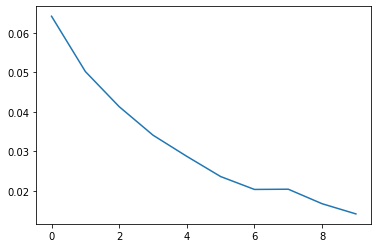

In [ ]:
plt.plot(loss_hist)

# References
 - https://pytorch.org/tutorials/beginner/basics/data_tutorial.html